In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re, string, unicodedata
import nltk
import contractions
import inflect

import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import re

from wordcloud import WordCloud, STOPWORDS

import nltk
# import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer


from sklearn import metrics
from sklearn.model_selection import train_test_split
# from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import scipy

from gensim import corpora
from gensim import corpora
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities

import pickle
import time
import Utils as util

In [2]:
rev_busi_Pho= pd.read_csv('../data/filtered_reviews_in_Phonex.csv', parse_dates=["date"])
train_valid_df  = pickle.load(open('../data/train_valid_df.pkl', "rb"))
test_df = pickle.load(open('../data/test_df.pkl', "rb"))

train_df  = pickle.load(open('../data/train_df.pkl', "rb"))
valid_df = pickle.load(open('../data/valid_df.pkl', "rb"))

bus_df_subset = pd.read_csv("../data/business_subset_cleaned.csv", index_col= "business_id")
print("unique users in training set:", train_valid_df["user_id"].nunique())
print("unique businesses in training set:", train_valid_df["business_id"].nunique())
print("unique users in test set:", test_df["user_id"].nunique())
print("unique businesses in test set:", test_df["business_id"].nunique())

unique users in training set: 19683
unique businesses in training set: 1728
unique users in test set: 19500
unique businesses in test set: 1672


In [3]:
t0 = time.time()
df_pred_results_lsi1 = pd.DataFrame(columns= ["ks","n_topics","sample_size", "rmse", "mae"])
# sample_sizes = [100]
ks = [20, 50, 100]
n_topics = [50, 100, 150, 200]
df_texts = pickle.load(open('../data/text_train_valid_df.pkl', "rb"))
# for sample_size in sample_sizes:
for k in ks:
    for n_topic in n_topics:
        test = util.CB_LSI_predict(df_texts,train_df, valid_df, k = k, n_topics = n_topic)
        rmse = mean_squared_error(test.dropna().pred_lsi, test.dropna().ratings)**0.5
        mae = mean_absolute_error(test.dropna().pred_lsi, test.dropna().ratings)
        df_pred_results_lsi1 = df_pred_results_lsi1.append({"ks": k, "n_topics": n_topic,"sample_size": len(test_df),
                                "rmse": rmse, "mae": mae}, ignore_index = True)
t1=  time.time()
print("time elapsed: (seconds)")
print(np.round(t1- t0,3))

df_pred_results_lsi1
print(df_pred_results_lsi1.loc[df_pred_results_lsi1["rmse"] == np.min(df_pred_results_lsi1.rmse),])



time elapsed: (seconds)
47987.291


,ks,n_topics,sample_size,rmse,mae
0,20.0,50.0,19500.0,1.338213,1.010043
1,20.0,100.0,19500.0,1.338301,1.010110


     ks  n_topics  sample_size      rmse       mae
0  20.0      50.0      19500.0  1.338213  1.010043


In [6]:
# df_pred_results_lsi1.to_csv("Results_CB_LSI_1.csv", index = False)

In [3]:
df_pred_results_lsi = pd.read_csv("../data/Results_CB_LSI.csv")

In [5]:
df_pred_results_lsi = df_pred_results_lsi.iloc[:,:5]

In [6]:
df_pred_results_lsi

,ks,n_topics,sample_size,rmse,mae
0,20,50,19500,1.338213,1.010043
1,20,100,19500,1.338301,1.010110
2,20,150,19500,1.338279,1.010076
3,20,200,19500,1.338272,1.010046
4,50,50,19500,1.338179,1.010061
5,50,100,19500,1.338097,1.010074
6,50,150,19500,1.338092,1.010049
7,50,200,19500,1.338099,1.010052
8,100,50,19500,1.338039,1.009953
9,100,100,19500,1.338047,1.009964


In [11]:
df_pred_results_lsi = pd.read_csv("../data/Results_CB_LSI.csv")
df_pred_results_lsi = df_pred_results_lsi[df_pred_results_lsi["ks"] == 50]

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'n_topics')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, 'Content Based Model (LSI) : n_topics vs MSE')

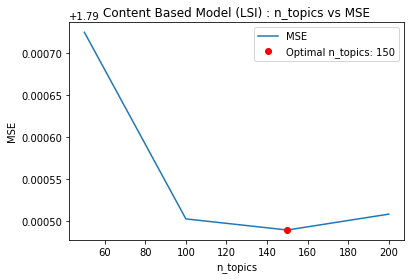

In [18]:
optimal = df_pred_results_lsi.loc[df_pred_results_lsi["rmse"] == np.min(df_pred_results_lsi.rmse),]
plt.figure()
plt.plot(df_pred_results_lsi["n_topics"], df_pred_results_lsi["rmse"]**2, label = "MSE")
plt.plot(optimal["n_topics"], optimal["rmse"]**2, "ro", label = "Optimal n_topics: {}".format(150))
plt.legend()
plt.xlabel("n_topics")
plt.ylabel("MSE")
plt.title("Content Based Model (LSI) : n_topics vs MSE")

In [21]:
df_pred_results_lsi[df_pred_results_lsi["rmse"] == df_pred_results_lsi.rmse.min()]

,ks,n_topics,sample_size,rmse,mae
8,100,50,19500,1.338039,1.009953


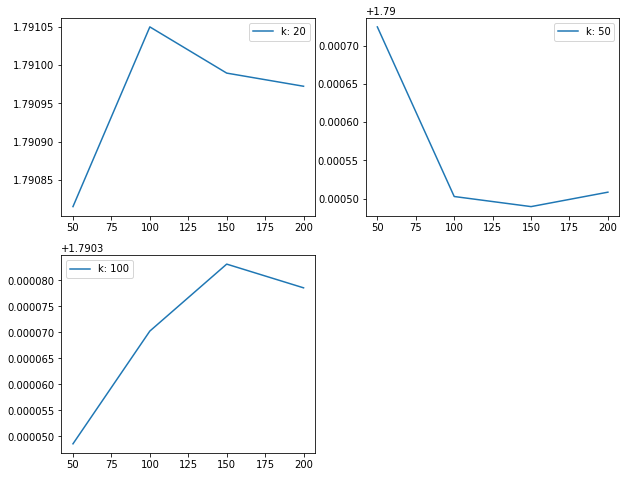

In [7]:
fig = plt.figure(figsize =(10,8))
for i, k in enumerate(df_pred_results_lsi["ks"].unique()):
    fig.add_subplot(2,2, i+1)
    plt.plot(df_pred_results_lsi[df_pred_results_lsi["ks"] == k]["n_topics"], \
             df_pred_results_lsi[df_pred_results_lsi["ks"] == k]["rmse"]**2, label = "k: {}".format(k))
    plt.legend(loc = "best")
    #     df_pred_results_lsi[df_pred_results_lsi["ks"] == k].plot("n_topics", "rmse", label = k)
plt.show()  

### *Old test results (seems results are not very stable)

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

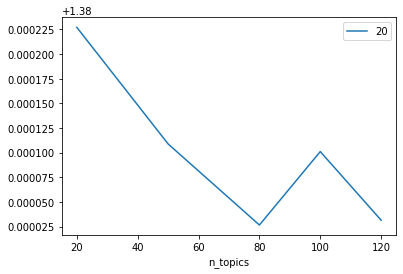

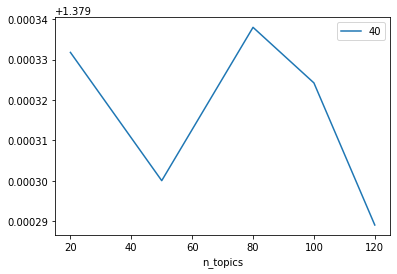

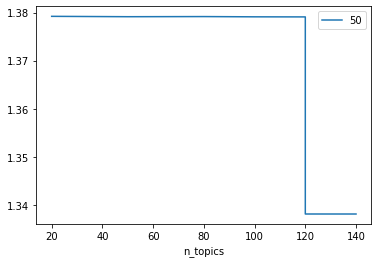

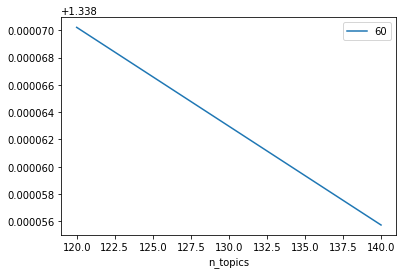

In [22]:
test = pd.read_csv("../data/Content_Based_Filtering_LSI.csv")
plt.figure(figsize =(10,8))
for k in test["ks"].unique():
    test[test["ks"] == k].plot("n_topics", "rmse", label = k)
plt.show()    

In [23]:
1.338092**2

1.7904902004640002